# Analysis of taxi trips

Notebooks consist of several parts: 
1. locations analysis for making spatial analysis 
2. temporal analysis of trips distributions in time
3. general properties: such as scaling etc. 

Notebook for the winter school WWCS for analysis of mobility data. 
Here we consider the data of taxi drivers in New York. 

In [2]:
from datetime import datetime
from geopy.distance import geodesic
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt


# Loading data

Here we load data of transportation of taxis around NY from open Kaggle dataset as you can find here https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

In [ ]:

df = pd.read_csv('taxi_test.csv',sep=',')
df.head()

Reading and slicing the data-set for making plots

In [159]:


df = pd.read_csv('/home/user1/Documents/Data_Analysis/nyc-taxi-trip-duration/time_zone_3.csv',sep=' ')

df_new = df[df.Distance > 20]
df_new = df_new[df_new.Distance <= 21]

df_new["Duration(seconds)"] = df_new["Duration(seconds)"]/60

q1 = df_new["Duration(seconds)"].quantile(0.25)
q3 = df_new["Duration(seconds)"].quantile(0.75)

iqr = q3-q1

low_end = max(q1 - 1.5*iqr,0)
high_end = q3 + 1.5*iqr

#     print(low_end, high_end)

df_new = df_new[df_new["Duration(seconds)"] <= high_end]

df_new.sort_values("Duration(seconds)")

,tripID,Date,Time,Distance,Duration(seconds),pick_long,pick_lat,drop_long,drop_lat
64696,id1247921,2016-01-11,11:56:08,20.657,14.000000,-73.784966,40.648548,-73.956734,40.780918
45667,id2617414,2016-03-20,08:53:43,20.734,17.416667,-73.929337,40.799358,-73.791794,40.644730
249656,id1261113,2016-02-14,09:45:22,20.203,19.400000,-73.972603,40.749142,-73.776352,40.645279
167522,id1063807,2016-01-01,09:52:20,20.038,20.083333,-73.976379,40.744179,-73.778358,40.644970
115417,id0787003,2016-02-28,08:49:28,20.145,20.583333,-73.985603,40.746841,-73.789932,40.643261
...,...,...,...,...,...,...,...,...,...
222629,id2882564,2016-03-04,08:39:24,20.722,86.983333,-73.781921,40.644772,-73.999809,40.730282
188401,id0243188,2016-05-04,08:53:11,20.638,87.516667,-73.789368,40.646561,-73.977867,40.764721
28959,id2869946,2016-05-06,09:10:24,20.938,87.666667,-73.776787,40.645489,-73.983612,40.749271
19119,id1694351,2016-06-16,11:31:34,20.695,87.833333,-73.789757,40.643349,-73.975426,40.764854


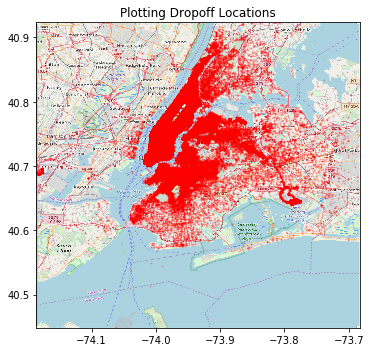

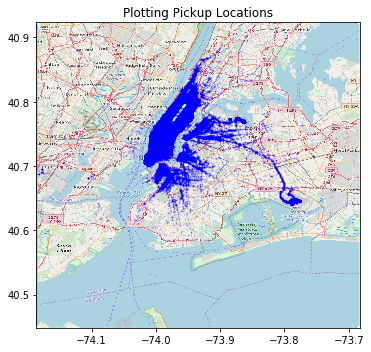

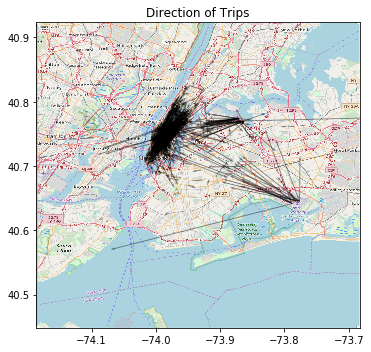

In [164]:

############# geographic locations of the trips ###################

BBox = (-74.1859, -73.6826, 40.4485, 40.9234)
# BBox = (-74.0293, -73.8939, 40.6982, 40.8687)

nyc = plt.imread('/home/user1/Documents/Data_Analysis/nyc-taxi-trip-duration/nyc.png')
# nyc = plt.imread('/home/user1/Documents/Data_Analysis/nyc-taxi-trip-duration/nyc_2.png')


x_pos, y_pos = list(df.pickup_longitude), list(df.pickup_latitude)
x_f,y_f = list(df.dropoff_longitude), list(df.dropoff_latitude)

d_x = list(map(lambda x: x[0]-x[1], zip(x_f,x_pos)))
d_y = list(map(lambda x: x[0]-x[1], zip(y_f,y_pos)))

fig, ax = plt.subplots(figsize = (8,5))
# ax.scatter(df.pick_long, df.pick_lat, zorder=2, alpha= 0.2, c='b', s=15)
ax.scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha= 0.3, c='r', s=0.5)
ax.set_title('Plotting Dropoff Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig('/home/user1/Documents/Data_Analysis/nyc-taxi-trip-duration/plots/dropoff_points.png')
plt.show()


fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(df.pickup_longitude, df.pickup_latitude, zorder=2, alpha= 0.2, c='b', s=0.5)
# ax.scatter(df.drop_long, df.drop_lat, zorder=1, alpha= 0.3, c='r', s=15)
ax.set_title('Plotting Pickup Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig('/home/user1/Documents/Data_Analysis/nyc-taxi-trip-duration/plots/pickup_points.png')
plt.show()


fig, ax = plt.subplots(figsize = (8,5))
ax.quiver(x_pos[::500],y_pos[::500],d_x[::500],d_y[::500], scale=1 , alpha=0.5, color='black')
ax.set_title('Direction of Trips')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig('/home/user1/Documents/Data_Analysis/nyc-taxi-trip-duration/plots/quiver_diag.png')
plt.show()


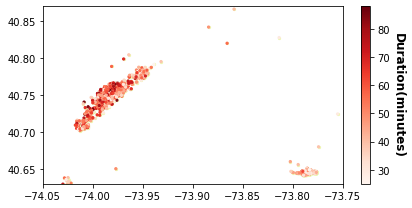

In [160]:

######################## Places that take longer time to reach ##############################

BBox = (-74.05, -73.75, 40.63, 40.87)
xmin,xmax,ymin,ymax = BBox[0],BBox[1],BBox[2],BBox[3]
# x0,y0 = df.pickup_longitude, df.pickup_latitude
x,y,z = df_new.drop_long, df_new.drop_lat, df_new["Duration(seconds)"]

Drop = list(zip(x,y,z))


x1,y1,z1 = [],[],[]

for i,j,k in Drop:
    
    if k>=25:
        
        x1.append(i)
        y1.append(j)
        z1.append(k)

fig, ax = plt.subplots(figsize = (6,3))

from matplotlib import cm

# ax.scatter(x0,y0, zorder=1, alpha= 0.3, c='b', s=0.3)
ax.scatter(x,y, zorder=1, alpha= 1, c='#edf8b1', s=5)
# ax.set_title('Plotting Dropoff Locations')

xx = np.ravel(x1); yy = np.ravel(y1) ; zz = np.ravel(z1)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

plt.scatter(xx,yy,c=zz,cmap=cm.Reds,s=5)
cbar = plt.colorbar()
cbar.set_label("Duration(minutes)", labelpad=15,rotation=270, fontsize=12,fontweight='bold')
plt.tight_layout()
plt.savefig('/home/user1/Documents/Data_Analysis/nyc-taxi-trip-duration/plots/hotzones_21km_8to12.png')
plt.show()


In [136]:
# from matplotlib import cm
# xx = np.ravel(x); yy = np.ravel(y) ; zz = np.ravel(z)
# plt.scatter(xx,yy,c=zz,cmap=cm.Reds)
# plt.colorbar()

# plt.hexbin(x,y,gridsize=50)
# plt.xlim(xmin,xmax)
# plt.ylim(ymin,ymax)

In [30]:
from datetime import datetime
from geopy.distance import geodesic
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

df = pd.read_csv('/home/user1/Documents/Data_Analysis/nyc/train.csv',sep=',')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


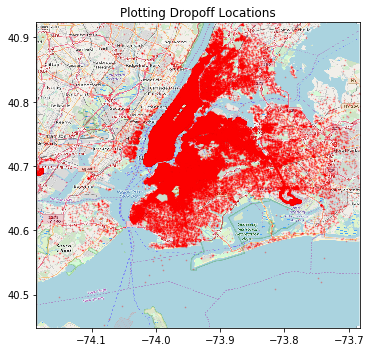

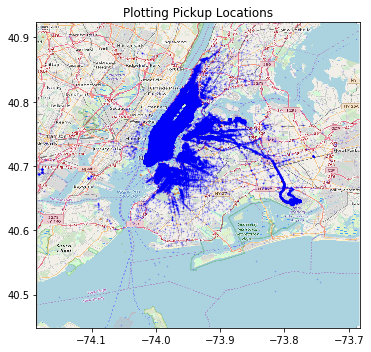

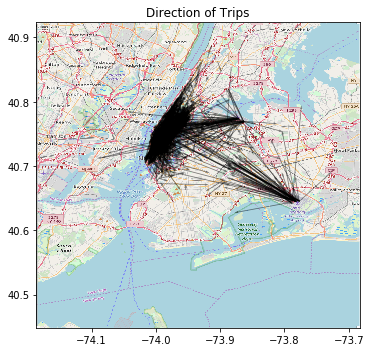

In [32]:
BBox = (-74.1859, -73.6826, 40.4485, 40.9234)
# BBox = (-74.0293, -73.8939, 40.6982, 40.8687)

# nyc = plt.imread('/home/user1/Documents/Data_Analysis/nyc/nyc.png')
# nyc = plt.imread('/home/user1/Documents/Data_Analysis/nyc-taxi-trip-duration/nyc_2.png')


x_pos, y_pos = list(df.pickup_longitude), list(df.pickup_latitude)
x_f,y_f = list(df.dropoff_longitude), list(df.dropoff_latitude)

d_x = list(map(lambda x: x[0]-x[1], zip(x_f,x_pos)))
d_y = list(map(lambda x: x[0]-x[1], zip(y_f,y_pos)))

fig, ax = plt.subplots(figsize = (8,5))
# ax.scatter(df.pick_long, df.pick_lat, zorder=2, alpha= 0.2, c='b', s=15)
ax.scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha= 0.3, c='r', s=0.5)
ax.set_title('Plotting Dropoff Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig('/home/user1/Documents/Data_Analysis/nyc/plots/dropoff_points_f.png')
plt.show()


fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(df.pickup_longitude, df.pickup_latitude, zorder=2, alpha= 0.2, c='b', s=0.5)
# ax.scatter(df.drop_long, df.drop_lat, zorder=1, alpha= 0.3, c='r', s=15)
ax.set_title('Plotting Pickup Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig('/home/user1/Documents/Data_Analysis/nyc/plots/pickup_points_f.png')
plt.show()


fig, ax = plt.subplots(figsize = (8,5))
ax.quiver(x_pos[::500],y_pos[::500],d_x[::500],d_y[::500], scale=1 , alpha=0.5, color='black')
ax.set_title('Direction of Trips')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig('/home/user1/Documents/Data_Analysis/nyc/plots/quiver_diag_f.png')
plt.show()